In [1]:
import sys
import os
import logging
import ast
import re

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('display.max_colwidth', None)
from scipy import stats
from scipy.special import rel_entr

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

In [2]:
def set_style(fsz=14):
    sns.set_context("paper")    
    plt.rc('font', family='Linux Libertine')
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2  # previous pdf hatch linewidth
    
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

In [3]:
sys.path.insert(1, '/scratchNVM0/ndhuynh/robust-lsm-tuning/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning

config = DataProvider.read_config('/scratchNVM0/ndhuynh/robust-lsm-tuning/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)

# Generating Workloads for Exp02 Exp03

In [4]:
def apply_design(d, cf, z0, z1, q, w):
    cf.z0, cf.z1, cf.q, cf.w = z0, z1, q, w
    cost = cf.calculate_cost(d['M_filt'] / cf.N, np.ceil(d['T']), d['is_leveling_policy'])

    return cost

def get_cumulative_data(df, wl_idx, robust_rho, samples):
    df_sample = df[(df.workload_idx == wl_idx) & (df.robust_rho == robust_rho)]
    sessions = []
    sessions.append(df_sample[df_sample.z0_s + df_sample.z1_s > 0.8].sample(samples, replace=True, random_state=0))
    sessions.append(df_sample[df_sample.q_s > 0.8].sample(samples, replace=True, random_state=0))
    sessions.append(df_sample[df_sample.z0_s > 0.8].sample(samples, replace=True, random_state=0))
    sessions.append(df_sample[df_sample.z1_s > 0.8].sample(samples, replace=True, random_state=0))
    sessions.append(df_sample[df_sample.w_s > 0.8].sample(samples, replace=True, random_state=0))
    sessions.append(df_sample[df_sample.rho_hat < 0.2].sample(samples, replace=True, random_state=0))
    
    data = pd.concat(sessions, ignore_index=True)
    data[['robust_cost_cum', 'nominal_cost_cum']] = data[['robust_cost', 'nominal_cost']].cumsum()
    
    w_hat = data[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w = ast.literal_eval(data.iloc[0].w)
    w0 = [w['z0'], w['z1'], w['q'], w['w']]
    distance = np.sum(rel_entr(w_hat, w0))

    cfg = config['lsm_tree_config'].copy()
    cfg['N'] = df.iloc[0].N
    cfg['M'] = df.iloc[0].M
    cf = CostFunction(**cfg, z0=w_hat[0], z1=w_hat[1], q=w_hat[2], w=w_hat[3])

    designer = NominalWorkloadTuning(cf)
    design_nom_s = designer.get_nominal_design()
    
    data['nominal_perfect_cost'] = data.apply(lambda row: apply_design(design_nom_s, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s']), axis=1)
    data['nominal_perfect_cost_cum'] = data['nominal_perfect_cost'].cumsum()
    data['nominal_perfect_T'] = design_nom_s['T']
    data['nominal_perfect_m_filt'] = design_nom_s['M_filt']
    data['nominal_perfect_is_leveling_policy'] = design_nom_s['is_leveling_policy']
    
    design_robust = {}
    design_robust['T'] = np.ceil(data['robust_T'].iloc[0])
    design_robust['M_filt'] = data['robust_m_filt'].iloc[0]
    design_robust['is_leveling_policy'] = data['robust_is_leveling_policy'].iloc[0]
    data['robust_cost'] = data.apply(lambda row: apply_design(design_robust, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s']), axis=1)
    
    design_nominal = {}
    design_nominal['T'] = np.ceil(data['nominal_T'].iloc[0])
    design_nominal['M_filt'] = data['nominal_m_filt'].iloc[0]
    design_nominal['is_leveling_policy'] = data['nominal_is_leveling_policy'].iloc[0]
    data['nominal_cost'] = data.apply(lambda row: apply_design(design_nominal, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s']), axis=1)
    
    return data, sessions

In [8]:
dp = DataProvider(config)
df = dp.read_csv('exp_01_1e8.csv')
df['robust_cost'] = np.around(df['robust_cost'], 4)
df['nominal_cost'] = np.around(df['nominal_cost'], 4)
df['robust_rho'] = np.around(df['robust_rho'], 2)
df['z_score'] = df.groupby(['workload_idx', 'robust_rho']).rho_hat.transform(lambda x: np.abs(stats.zscore(x)))
df[['z0_s', 'z1_s', 'q_s', 'w_s']] = df['w_hat'].str.extract(r"{'z0': ([0-9.]+), 'z1': ([0-9.]+), 'q': ([0-9.]+), 'w': ([0-9.]+)}")
df[['z0_s', 'z1_s', 'q_s', 'w_s']] = df[['z0_s', 'z1_s', 'q_s', 'w_s']].astype(np.float64)
df.describe()

,workload_idx,N,M,robust_rho,robust_m_filt,robust_T,robust_exit_mode,nominal_m_filt,nominal_T,rho_hat,sample_idx,nominal_cost,robust_cost,z_score,z0_s,z1_s,q_s,w_s
count,8.640000e+06,8640000.0,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06
mean,8.500000e+00,100000000.0,1.500000e+09,1.875000e+00,1.710512e+08,6.057576e+00,2.083333e-02,5.519066e+08,2.058787e+01,1.370811e+00,4.999500e+03,5.159615e+00,2.701763e+00,7.930993e-01,2.513584e-01,2.511446e-01,2.481513e-01,2.493440e-01
std,5.188128e+00,0.0,4.082483e+08,1.152443e+00,1.662915e+08,7.905549e+00,4.325113e-01,3.955914e+08,2.716106e+01,8.458691e-01,2.886751e+03,3.894359e+00,1.294931e+00,6.090924e-01,1.402882e-01,1.416221e-01,1.418426e-01,1.408217e-01
min,0.000000e+00,100000000.0,1.000000e+09,0.000000e+00,1.000000e+08,2.000000e+00,0.000000e+00,0.000000e+00,2.298706e+00,1.330878e-04,0.000000e+00,1.447000e-01,2.058000e-01,2.967082e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,100000000.0,1.000000e+09,9.375000e-01,1.000000e+08,4.659797e+00,0.000000e+00,2.631811e+08,5.132782e+00,6.975509e-01,2.499750e+03,2.457800e+00,2.213400e+00,3.254932e-01,1.453750e-01,1.453000e-01,1.385000e-01,1.435750e-01
50%,8.500000e+00,100000000.0,1.500000e+09,1.875000e+00,1.000000e+08,4.998932e+00,0.000000e+00,5.013878e+08,6.454354e+00,1.300226e+00,4.999500e+03,3.296900e+00,2.556000e+00,6.752890e-01,2.509000e-01,2.507000e-01,2.474500e-01,2.500000e-01
75%,1.300000e+01,100000000.0,2.000000e+09,2.812500e+00,1.000000e+08,5.095223e+00,0.000000e+00,8.892605e+08,1.728771e+01,1.927153e+00,7.499250e+03,7.334100e+00,2.921200e+00,1.123176e+00,3.444000e-01,3.432500e-01,3.412000e-01,3.413000e-01
max,1.700000e+01,100000000.0,2.000000e+09,3.750000e+00,1.288188e+09,1.000000e+02,9.000000e+00,1.289815e+09,1.000000e+02,4.330997e+00,9.999000e+03,3.458760e+01,4.146120e+01,6.634283e+00,9.327000e-01,8.971000e-01,8.788000e-01,9.029000e-01


In [9]:
sample_wl = []

samples = 5
wl_rho = [(7, 2), (11, 0.25), (17, 0.5)]
for widx, rho in wl_rho:
    data, _ = get_cumulative_data(df, widx, rho, samples)
    sample_wl.append(data)

sample_wl = pd.concat(sample_wl, ignore_index=True)
de.export_csv_file(sample_wl, 'experiment_02_wls.csv')
sample_wl


,workload_idx,w,N,M,robust_rho,robust_m_filt,robust_T,robust_is_leveling_policy,robust_exit_mode,nominal_m_filt,nominal_T,nominal_is_leveling_policy,rho_hat,w_hat,sample_idx,nominal_cost,robust_cost,z_score,z0_s,z1_s,q_s,w_s,robust_cost_cum,nominal_cost_cum,nominal_perfect_cost,nominal_perfect_cost_cum,nominal_perfect_T,nominal_perfect_m_filt,nominal_perfect_is_leveling_policy
0,7,"{'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}",100000000.0,1.500000e+09,2.00,1.000000e+08,4.638658,True,0,9.838321e+08,9.571805,False,0.982163,"{'z0': 0.6491, 'z1': 0.2807, 'q': 0.0, 'w': 0.0702}",8321,0.515257,1.338845,0.713444,0.6491,0.2807,0.0000,0.0702,1.3386,0.4660,0.769588,0.769588,4.135594,4.078109e+08,True
1,7,"{'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}",100000000.0,1.500000e+09,2.00,1.000000e+08,4.638658,True,0,9.838321e+08,9.571805,False,1.744244,"{'z0': 0.3317, 'z1': 0.4712, 'q': 0.0962, 'w': 0.101}",5026,4.815980,1.707542,0.456865,0.3317,0.4712,0.0962,0.1010,3.0110,3.8306,1.448900,2.218489,4.135594,4.078109e+08,True
2,7,"{'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}",100000000.0,2.000000e+09,2.00,1.000000e+08,4.622132,True,0,1.108616e+09,10.177384,False,2.011269,"{'z0': 0.2992, 'z1': 0.5748, 'q': 0.0079, 'w': 0.1181}",2191,1.217526,1.476057,0.866928,0.2992,0.5748,0.0079,0.1181,4.4258,4.8078,1.224862,3.443350,4.135594,4.078109e+08,True
3,7,"{'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}",100000000.0,2.000000e+09,2.00,1.000000e+08,4.622132,True,0,1.108616e+09,10.177384,False,0.883762,"{'z0': 0.5625, 'z1': 0.2891, 'q': 0.0156, 'w': 0.1328}",404,1.307183,1.578599,0.864556,0.5625,0.2891,0.0156,0.1328,5.9421,5.7367,1.106692,4.550042,4.135594,4.078109e+08,True
4,7,"{'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}",100000000.0,2.000000e+09,2.00,1.000000e+08,4.622132,True,0,1.108616e+09,10.177384,False,1.836766,"{'z0': 0.3978, 'z1': 0.4696, 'q': 0.0939, 'w': 0.0387}",7699,4.592586,1.508741,0.598948,0.3978,0.4696,0.0939,0.0387,7.4215,8.8286,1.174377,5.724418,4.135594,4.078109e+08,True
5,7,"{'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}",100000000.0,1.500000e+09,2.00,1.000000e+08,4.638658,True,0,9.838321e+08,9.571805,False,3.380690,"{'z0': 0.0566, 'z1': 0.0, 'q': 0.8302, 'w': 0.1132}",3844,35.399041,4.060020,2.969913,0.0566,0.0000,0.8302,0.1132,11.3656,32.2200,4.254644,9.979063,4.135594,4.078109e+08,True
6,7,"{'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}",100000000.0,1.500000e+09,2.00,1.000000e+08,4.638658,True,0,9.838321e+08,9.571805,False,3.805398,"{'z0': 0.0273, 'z1': 0.1091, 'q': 0.8364, 'w': 0.0273}",5427,35.590002,3.801952,3.622127,0.0273,0.1091,0.8364,0.0273,15.0898,55.7695,3.998796,13.977859,4.135594,4.078109e+08,True
7,7,"{'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}",100000000.0,2.000000e+09,2.00,1.000000e+08,4.622132,True,0,1.108616e+09,10.177384,False,3.380690,"{'z0': 0.0566, 'z1': 0.0, 'q': 0.8302, 'w': 0.1132}",3844,35.399041,4.060020,2.969913,0.0566,0.0000,0.8302,0.1132,18.8554,78.3335,4.254644,18.232503,4.135594,4.078109e+08,True
8,7,"{'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}",100000000.0,1.000000e+09,2.00,1.000000e+08,4.660179,True,0,7.765774e+08,7.998662,False,3.705985,"{'z0': 0.0, 'z1': 0.1205, 'q': 0.8072, 'w': 0.0723}",199,34.457620,3.849137,3.469460,0.0000,0.1205,0.8072,0.0723,22.8485,100.8882,4.074112,22.306616,4.135594,4.078109e+08,True
9,7,"{'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}",100000000.0,1.000000e+09,2.00,1.000000e+08,4.660179,True,0,7.765774e+08,7.998662,False,3.380690,"{'z0': 0.0566, 'z1': 0.0, 'q': 0.8302, 'w': 0.1132}",3844,35.399041,4.060020,2.969913,0.0566,0.0000,0.8302,0.1132,27.0510,124.0326,4.254644,26.561260,4.135594,4.078109e+08,True


# Plotting Data

In [7]:
def plot_cost_sessions(df, samples, num_operations, readonly=False):
    df = df.copy().reset_index()
    num_sessions = df.shape[0] / samples
    PAGESIZE = 4096
    
    means = []
    for idx in range(0, data.shape[0], samples):
        means.append(data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)].iloc[idx:idx+samples][['z0_s', 'z1_s', 'q_s', 'w_s']].mean())
        
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w = ast.literal_eval(df.iloc[0].w)
    w0 = [w['z0'], w['z1'], w['q'], w['w']]
    distance = np.sum(rel_entr(w_hat, w0))

    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    
    nominal_compaction_ios = np.sum((df['nominal_compact_read'] + df['nominal_compact_write']) / PAGESIZE)
    robust_compaction_ios = np.sum((df['robust_compact_read'] + df['robust_compact_write']) / PAGESIZE)
    workload_weight = df['w_s'] / df['w_s'].sum()
    df['nominal_write_io'] = (workload_weight * nominal_compaction_ios) + ((df['robust_bytes_written'] + df['nominal_flush_written']) / PAGESIZE)
    df['robust_write_io'] = (workload_weight * robust_compaction_ios) + ((df['robust_bytes_written'] + df['robust_flush_written']) / PAGESIZE)
    df['nominal_io'] = df['nominal_blocks_read'] + df['nominal_write_io']
    df['robust_io'] = df['robust_blocks_read'] +  df['robust_write_io'] 
    
    y1, y2 = df['nominal_io'].values, df['robust_io'].values
        
    fig, axes = plt.subplots(ncols=1, nrows=2)
    system_ax, model_ax = axes
    
    for ax in axes:
        ax.set_xlim(left=-0.25, right=(num_sessions * samples) - 0.75)
        for bounds in np.arange(samples - 1, num_sessions * samples - 1, samples):
            ax.axvline(x=bounds + 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)
    
    # Systems Graph
    system_ax.text(16.3, 7, 'System', fontsize=16)
    system_ax.set_xticklabels([])
    system_ax.set_xticks([])
    system_ax.plot(df.index.values, y1 / num_operations, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    system_ax.plot(df.index.values, y2 / num_operations, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    system_ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, framealpha=1, edgecolor='black', fancybox=False, ncol=2)
    
    
    # Model Graph
    model_ax.text(16.3, 7, 'Model', fontsize=16)
    y1, y2 = df.nominal_cost, df.robust_cost
    model_ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    model_ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    
    model_ax.set_xticks([(samples)/2 - 0.25] + [x + 0.5 for x in np.arange((samples/2) + samples - 1, num_sessions * samples - 1, samples)])
    model_ax.text( 0.5, -1.6, f'({(means[0].z0_s * 100):.0f}%, {(means[0].z1_s * 100):.0f}%, {(means[0].q_s * 100):.0f}%, {(means[0].w_s * 100):.0f}%)', alpha=1)
    model_ax.text( 5.5, -1.6, f'({(means[1].z0_s * 100):.0f}%, {(means[1].z1_s * 100):.0f}%, {(means[1].q_s * 100):.0f}%, {(means[1].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(10.5, -1.6, f'({(means[2].z0_s * 100):.0f}%, {(means[2].z1_s * 100):.0f}%, {(means[2].q_s * 100):.0f}%, {(means[2].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(15.5, -1.6, f'({(means[3].z0_s * 100):.0f}%, {(means[3].z1_s * 100):.0f}%, {(means[3].q_s * 100):.0f}%, {(means[3].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(20.5, -1.6, f'({(means[4].z0_s * 100):.0f}%, {(means[4].z1_s * 100):.0f}%, {(means[4].q_s * 100):.0f}%, {(means[4].w_s * 100):.0f}%)', alpha=1)

    if readonly:
        model_ax.set_xticklabels(['1. Expected', '2. Reads', '3. Range', '4. Empty Reads', '5. Non-Empty Reads'])
    else:
        model_ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])
        model_ax.text(25.3, -1.55, f'({(means[5].z0_s * 100):.0f}%, {(means[5].z1_s * 100):.0f}%, {(means[5].q_s * 100):.0f}%, {(means[5].w_s * 100):.0f}%)', alpha=1)
    
    fig.supylabel('Average I/Os per Query')
    
    system_ax.text(24.60, 7, '$w:\ $' + f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)')
    system_ax.text(24.60, 6, '$\hat{w}:\ $' + f'({(w_hat[0] * 100):.0f}%, {(w_hat[1] * 100):.0f}%, {(w_hat[2] * 100):.0f}%, {(w_hat[3] * 100):.0f}%)')
    
    model_ax.text(25.61, 7, '$I_{KL}(\hat{w}, w) :$' + f'{distance:.2f}')
    model_ax.text(27.33, 6, r'$\rho :$' + f'{robust_rho:.2f}')

    
    return fig, axes

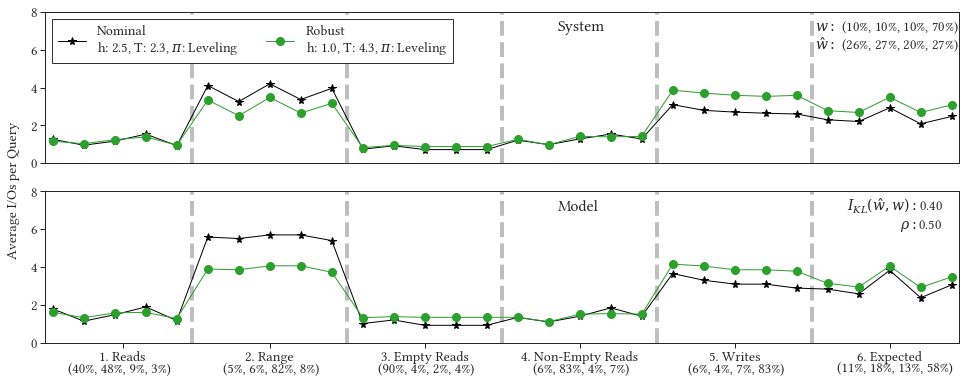

In [8]:
wl_idx, robust_rho, samples, num_operations = (15, 0.5, 5, 10000)

data = dp.read_csv('viz_data/exp07_10mill.csv')

set_style()
fig, axes = plot_cost_sessions(data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)], samples, num_operations, readonly=False)
axes[0].set_ylim([0, 8])
axes[1].set_ylim([0, 8])
set_size(fig, width=2*7, height=2*2.75)
save_fig(fig, 'query_seq_hybrid_1.pdf')

In [9]:
def plot_cost_sessions(df, samples, num_operations, readonly=False):
    df = df.copy().reset_index()
    num_sessions = df.shape[0] / samples
    PAGESIZE = 4096
    
    means = []
    for idx in range(0, data.shape[0], samples):
        means.append(data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)].iloc[idx:idx+samples][['z0_s', 'z1_s', 'q_s', 'w_s']].mean())

    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w = ast.literal_eval(df.iloc[0].w)
    w0 = [w['z0'], w['z1'], w['q'], w['w']]
    distance = np.sum(rel_entr(w_hat, w0))

    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    
    nominal_compaction_ios = np.sum((df['nominal_compact_read'] + df['nominal_compact_write']) / PAGESIZE)
    robust_compaction_ios = np.sum((df['robust_compact_read'] + df['robust_compact_write']) / PAGESIZE)
    workload_weight = df['w_s'] / df['w_s'].sum()
    df['nominal_write_io'] = (workload_weight * nominal_compaction_ios) + ((df['robust_bytes_written'] + df['nominal_flush_written']) / PAGESIZE)
    df['robust_write_io'] = (workload_weight * robust_compaction_ios) + ((df['robust_bytes_written'] + df['robust_flush_written']) / PAGESIZE)
    df['nominal_io'] = df['nominal_blocks_read'] + df['nominal_write_io']
    df['robust_io'] = df['robust_blocks_read'] +  df['robust_write_io'] 
    
    y1, y2 = df['nominal_io'].values, df['robust_io'].values
        
    fig, axes = plt.subplots(ncols=1, nrows=2)
    system_ax, model_ax = axes
    
    for ax in axes:
        ax.set_xlim(left=-0.25, right=(num_sessions * samples) - 0.75)
        for bounds in np.arange(samples - 1, num_sessions * samples - 1, samples):
            ax.axvline(x=bounds + 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)
    
    # Systems Graph
    system_ax.text(16.3, 830, 'System', fontsize=16)
    system_ax.set_xticklabels([])
    system_ax.set_xticks([])
    system_ax.plot(df.index.values, y1 / num_operations, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    system_ax.plot(df.index.values, y2 / num_operations, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    system_ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, framealpha=1, edgecolor='black', fancybox=False, ncol=2)
    
    system_ax.text(24.50, 830, '$w_{11}:$' + f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)')
    system_ax.text(24.60, 700, '$\hat{w}:$' + f'({(w_hat[0] * 100):.0f}%, {(w_hat[1] * 100):.0f}%, {(w_hat[2] * 100):.0f}%, {(w_hat[3] * 100):.0f}%)')
    
    
    # Model Graph
    model_ax.text(16.3, 17.5, 'Model', fontsize=16)
    y1, y2 = df.nominal_cost, df.robust_cost
    model_ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    model_ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    
    model_ax.set_xticks([(samples)/2 - 0.25] + [x + 0.5 for x in np.arange((samples/2) + samples - 1, num_sessions * samples - 1, samples)])
    model_ax.text( 0.5, -4.6, f'({(means[0].z0_s * 100):.0f}%, {(means[0].z1_s * 100):.0f}%, {(means[0].q_s * 100):.0f}%, {(means[0].w_s * 100):.0f}%)', alpha=1)
    model_ax.text( 5.5, -4.6, f'({(means[1].z0_s * 100):.0f}%, {(means[1].z1_s * 100):.0f}%, {(means[1].q_s * 100):.0f}%, {(means[1].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(10.5, -4.6, f'({(means[2].z0_s * 100):.0f}%, {(means[2].z1_s * 100):.0f}%, {(means[2].q_s * 100):.0f}%, {(means[2].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(15.5, -4.6, f'({(means[3].z0_s * 100):.0f}%, {(means[3].z1_s * 100):.0f}%, {(means[3].q_s * 100):.0f}%, {(means[3].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(20.5, -4.6, f'({(means[4].z0_s * 100):.0f}%, {(means[4].z1_s * 100):.0f}%, {(means[4].q_s * 100):.0f}%, {(means[4].w_s * 100):.0f}%)', alpha=1)

    if readonly:
        model_ax.set_xticklabels(['1. Expected', '2. Reads', '3. Range', '4. Empty Reads', '5. Non-Empty Reads'])
    else:
        model_ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])
        model_ax.text(25.3, -4.6, f'({(means[5].z0_s * 100):.0f}%, {(means[5].z1_s * 100):.0f}%, {(means[5].q_s * 100):.0f}%, {(means[5].w_s * 100):.0f}%)', alpha=1)
    
    fig.supylabel('Average I/Os per Query')
    
    model_ax.text(25.25, 17, '$I_{KL}(\hat{w}, w_{11}) :$' + f'{distance:.2f}')
    model_ax.text(27.4, 15, r'$\rho :$' + f'{robust_rho:.2f}')

    
    return fig, axes

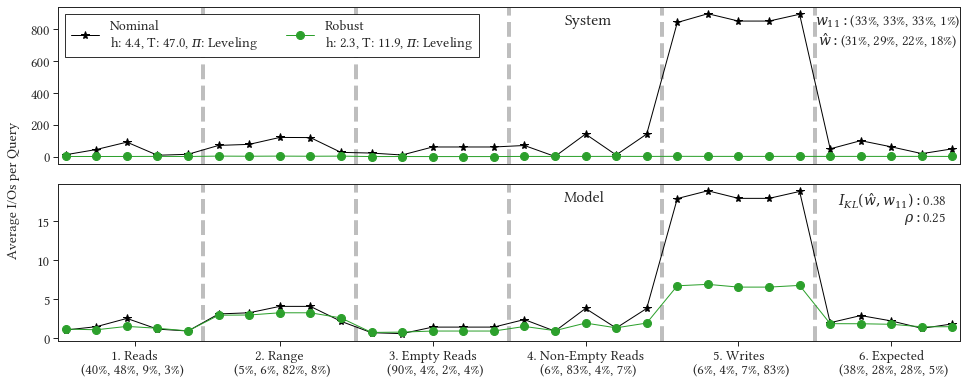

In [64]:
wl_idx, robust_rho, samples, num_operations = (11, 0.25, 5, 10000)

data = dp.read_csv('viz_data/exp07_10mill.csv')

set_style()
fig, axes = plot_cost_sessions(data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)], samples, num_operations, readonly=False)
set_size(fig, width=2*7, height=2*2.75)
save_fig(fig, 'query_seq_hybrid_2.pdf')

In [57]:
def plot_cost_sessions(df, samples, num_operations, readonly=False):
    df = df.copy().reset_index()
    num_sessions = df.shape[0] / samples
    PAGESIZE = 4096
    
    means = []
    for idx in range(0, data.shape[0], samples):
        means.append(data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)].iloc[idx:idx+samples][['z0_s', 'z1_s', 'q_s', 'w_s']].mean())
    
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w = ast.literal_eval(df.iloc[0].w)
    w0 = [w['z0'], w['z1'], w['q'], w['w']]
    distance = np.sum(rel_entr(w_hat, w0))

    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    
    nominal_compaction_ios = np.sum((df['nominal_compact_read'] + df['nominal_compact_write']) / PAGESIZE)
    robust_compaction_ios = np.sum((df['robust_compact_read'] + df['robust_compact_write']) / PAGESIZE)
    workload_weight = df['w_s'] / df['w_s'].sum()
    df['nominal_io'] = df['nominal_blocks_read']
    df['robust_io'] = df['robust_blocks_read'] 
    
    y1, y2 = df['nominal_io'].values, df['robust_io'].values
        
    fig, axes = plt.subplots(ncols=1, nrows=2)
    system_ax, model_ax = axes
    
    for ax in axes:
        ax.set_xlim(left=-0.25, right=(num_sessions * samples) - 0.75)
        ax.set_ylim([0, 6])
        for bounds in np.arange(samples - 1, num_sessions * samples - 1, samples):
            ax.axvline(x=bounds + 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)
    
    # Systems Graph
    system_ax.text(16.3, 5.3, 'System', fontsize=16)
    system_ax.set_xticklabels([])
    system_ax.set_xticks([])
    system_ax.plot(df.index.values, y1 / num_operations, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    system_ax.plot(df.index.values, y2 / num_operations, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    system_ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, framealpha=1, edgecolor='black', fancybox=False, ncol=2)
    
    system_ax.text(20.00, 5, '$w_{11}:$' + f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)')
    system_ax.text(20.33, 4.2, '$\hat{w}:$' + f'({(w_hat[0] * 100):.0f}%, {(w_hat[1] * 100):.0f}%, {(w_hat[2] * 100):.0f}%, {(w_hat[3] * 100):.0f}%)')
    
    
    # Model Graph
    model_ax.text(16.3, 5.3, 'Model', fontsize=16)
    y1, y2 = df.nominal_cost, df.robust_cost
    model_ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    model_ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    
    model_ax.set_xticks([(samples)/2 - 0.25] + [x + 0.5 for x in np.arange((samples/2) + samples - 1, num_sessions * samples - 1, samples)])
    model_ax.text( 0.8, -1.25, f'({(means[0].z0_s * 100):.0f}%, {(means[0].z1_s * 100):.0f}%, {(means[0].q_s * 100):.0f}%, {(means[0].w_s * 100):.0f}%)', alpha=1)
    model_ax.text( 5.8, -1.25, f'({(means[1].z0_s * 100):.0f}%, {(means[1].z1_s * 100):.0f}%, {(means[1].q_s * 100):.0f}%, {(means[1].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(10.8, -1.25, f'({(means[2].z0_s * 100):.0f}%, {(means[2].z1_s * 100):.0f}%, {(means[2].q_s * 100):.0f}%, {(means[2].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(15.8, -1.25, f'({(means[3].z0_s * 100):.0f}%, {(means[3].z1_s * 100):.0f}%, {(means[3].q_s * 100):.0f}%, {(means[3].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(20.8, -1.25, f'({(means[4].z0_s * 100):.0f}%, {(means[4].z1_s * 100):.0f}%, {(means[4].q_s * 100):.0f}%, {(means[4].w_s * 100):.0f}%)', alpha=1)

    if readonly:
        model_ax.set_xticklabels(['1. Expected', '2. Reads', '3. Range', '4. Empty Reads', '5. Non-Empty Reads'])
    
    fig.supylabel('Average I/Os per Query')
    
    model_ax.text(20.9, 5, '$I_{KL}(\hat{w}, w_{11}) :$' + f'{distance:.2f}')
    model_ax.text(22.6, 4.3, r'$\rho :$' + f'{robust_rho:.2f}')
    
    return fig, axes

|  (5, 0.5)  |  (7, 2.0)  |  (11, 0.25)  |  

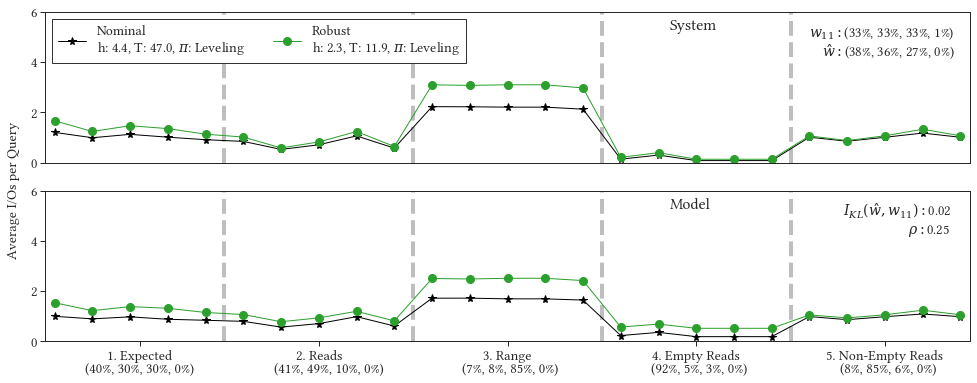

In [58]:
wl_idx, robust_rho, samples, num_operations = (11, 0.25, 5, 10000)

data = dp.read_csv('viz_data/exp06_10mill.csv')
print('|  ', end='')
_ = [print(key, end='  |  ') for key in data.groupby(['workload_idx', 'robust_rho']).groups.keys()]

set_style()
fig, axes = plot_cost_sessions(data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)], samples, num_operations, readonly=True)
set_size(fig, width=2*7, height=2*2.75)
save_fig(fig, 'query_seq_read_1.pdf')

In [69]:
def plot_cost_sessions(df, samples, num_operations, readonly=False):
    df = df.copy().reset_index()
    num_sessions = df.shape[0] / samples
    PAGESIZE = 4096
    
    means = []
    for idx in range(0, data.shape[0], samples):
        means.append(data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)].iloc[idx:idx+samples][['z0_s', 'z1_s', 'q_s', 'w_s']].mean())
        
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w = ast.literal_eval(df.iloc[0].w)
    w0 = [w['z0'], w['z1'], w['q'], w['w']]
    distance = np.sum(rel_entr(w_hat, w0))

    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    
    nominal_compaction_ios = np.sum((df['nominal_compact_read'] + df['nominal_compact_write']) / PAGESIZE)
    robust_compaction_ios = np.sum((df['robust_compact_read'] + df['robust_compact_write']) / PAGESIZE)
    workload_weight = df['w_s'] / df['w_s'].sum()
    df['nominal_io'] = df['nominal_blocks_read']
    df['robust_io'] = df['robust_blocks_read'] 
    
    y1, y2 = df['nominal_io'].values, df['robust_io'].values
        
    fig, axes = plt.subplots(ncols=1, nrows=2)
    system_ax, model_ax = axes
    
    for ax in axes:
        ax.set_xlim(left=-0.25, right=(num_sessions * samples) - 0.75)
        ax.set_ylim([0, 25])
        for bounds in np.arange(samples - 1, num_sessions * samples - 1, samples):
            ax.axvline(x=bounds + 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)
    
    # Systems Graph
    system_ax.text(16.3, 22, 'System', fontsize=16)
    system_ax.set_xticklabels([])
    system_ax.set_xticks([])
    system_ax.plot(df.index.values, y1 / num_operations, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    system_ax.plot(df.index.values, y2 / num_operations, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    system_ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, framealpha=1, edgecolor='black', fancybox=False, ncol=2)
    
    system_ax.text(20.00, 22, '$w_7:$' + f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)')
    system_ax.text(20.15, 19, '$\hat{w}:$' + f'({(w_hat[0] * 100):.0f}%, {(w_hat[1] * 100):.0f}%, {(w_hat[2] * 100):.0f}%, {(w_hat[3] * 100):.0f}%)')
    
    
    # Model Graph
    model_ax.text(16.3, 22, 'Model', fontsize=16)
    y1, y2 = df.nominal_cost, df.robust_cost
    model_ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    model_ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    
    model_ax.set_xticks([(samples)/2 - 0.25] + [x + 0.5 for x in np.arange((samples/2) + samples - 1, num_sessions * samples - 1, samples)])
    model_ax.text( 0.8, -5.00, f'({(means[0].z0_s * 100):.0f}%, {(means[0].z1_s * 100):.0f}%, {(means[0].q_s * 100):.0f}%, {(means[0].w_s * 100):.0f}%)', alpha=1)
    model_ax.text( 5.8, -5.00, f'({(means[1].z0_s * 100):.0f}%, {(means[1].z1_s * 100):.0f}%, {(means[1].q_s * 100):.0f}%, {(means[1].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(10.8, -5.00, f'({(means[2].z0_s * 100):.0f}%, {(means[2].z1_s * 100):.0f}%, {(means[2].q_s * 100):.0f}%, {(means[2].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(15.8, -5.00, f'({(means[3].z0_s * 100):.0f}%, {(means[3].z1_s * 100):.0f}%, {(means[3].q_s * 100):.0f}%, {(means[3].w_s * 100):.0f}%)', alpha=1)
    model_ax.text(20.8, -5.00, f'({(means[4].z0_s * 100):.0f}%, {(means[4].z1_s * 100):.0f}%, {(means[4].q_s * 100):.0f}%, {(means[4].w_s * 100):.0f}%)', alpha=1)

    if readonly:
        model_ax.set_xticklabels(['1. Expected', '2. Reads', '3. Range', '4. Empty Reads', '5. Non-Empty Reads'])
    
    fig.supylabel('Average I/Os per Query')
    
    model_ax.text(21.0, 22, '$I_{KL}(\hat{w}, w_{7}) :$' + f'{distance:.2f}')
    model_ax.text(22.6, 19, r'$\rho :$' + f'{robust_rho:.2f}')
    
    return fig, axes

|  (5, 0.5)  |  (7, 2.0)  |  (11, 0.25)  |  

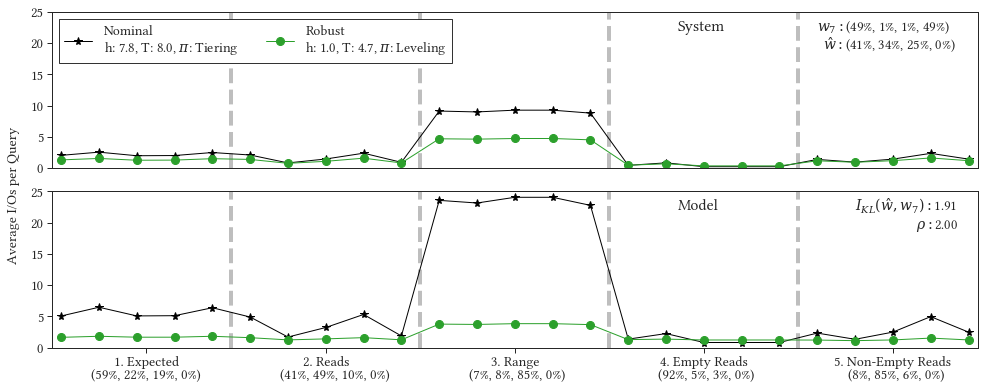

In [70]:
wl_idx, robust_rho, samples, num_operations = (7, 2, 5, 10000)

data = dp.read_csv('viz_data/exp06_10mill.csv')
print('|  ', end='')
_ = [print(key, end='  |  ') for key in data.groupby(['workload_idx', 'robust_rho']).groups.keys()]

set_style()
fig, axes = plot_cost_sessions(data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)], samples, num_operations, readonly=True)
set_size(fig, width=2*7, height=2*2.75)
save_fig(fig, 'query_seq_read_2.pdf')

# Plotting Ideal Figure

In [ ]:
def plot_cost_sessions(df, samples):
    df = df.copy().reset_index()
    num_sessions = df.shape[0] / samples
    
    means = []
    for idx in range(0, data.shape[0], samples):
        means.append(data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)].iloc[idx:idx+samples][['z0_s', 'z1_s', 'q_s', 'w_s']].mean())
        
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w = ast.literal_eval(df.iloc[0].w)
    w0 = [w['z0'], w['z1'], w['q'], w['w']]
    distance = np.sum(rel_entr(w_hat, w0))

    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    
    y1, y2 = df['nominal_cost'].values, df['nominal_perfect_cost'].values
    
    fig, ax = plt.subplots()
    
    ax.set_title('Query Sequence')
    ax.plot(df.index.values, y1, linewidth=1, linestyle='-' , marker='*', markersize=7, color='black',    label=f'Expected Tuning')
    ax.plot(df.index.values, y2, linewidth=1, linestyle='-', marker='x', markersize=7, color='tab:blue', label=f'Perfect Tuning')
    ax.legend(loc='upper left', bbox_to_anchor=(-0.03, 1.03), framealpha=1, fancybox=False, frameon=False)
    ax.set_xlim(left=-0.25, right=(num_sessions * samples) - 0.75)
    ax.set_ylabel('Average I/Os per Query')
    
    ax.set_xticks([(samples)/2 - 0.25] + [x + 0.5 for x in np.arange((samples/2) + samples - 1, num_sessions * samples - 1, samples)])
    ax.set_xticklabels(['1. Expected Workload', '2. Uncertain Workload', '3. Expected Workload'])
    
    ax.text(0.6, 3, f'Read Query: {(means[0].z0_s + means[0].z1_s) * 100:.0f}%\nRange Query: {((0.01 + means[0].q_s) * 100):.0f}%\nWrite Query: {(means[0].w_s * 100):.0f}%', alpha=0.75)
    ax.text(10.6, 1.8, f'Read Query: {(means[1].z0_s + means[1].z1_s) * 100:.0f}%\nRange Query: {((means[1].q_s - 0.01) * 100):.0f}%\nWrite Query: {(means[1].w_s * 100):.0f}%', alpha=0.75)
    ax.text(20.6, 3, f'Read Query: {(means[2].z0_s + means[2].z1_s) * 100:.0f}%\nRange Query: {((0.01 + means[2].q_s) * 100):.0f}%\nWrite Query: {(means[2].w_s * 100):.0f}%', alpha=0.75)

    for bounds in np.arange(samples - 1, num_sessions * samples - 1, samples):
        ax.axvline(x=bounds + 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)
    
    return fig, axes

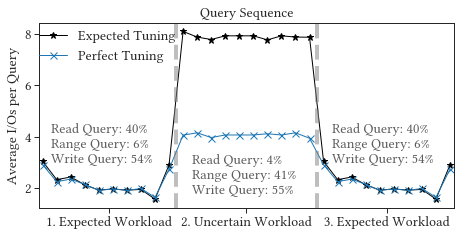

In [32]:
wl_idx, robust_rho, samples = 17, 0.5, 10

data = get_cumulative_data(df, wl_idx, robust_rho, samples)

set_style()
fig, ax = plot_cost_sessions(data, samples)
set_size(fig, width=2*3.33, height=2*1.75)
save_fig(fig, 'introduction_sequence.pdf')